# Video Classification and Contrastive Learning Experiments

This notebook performs experiments on video classification using C3D and R(2+1)D models. It includes baseline classification, multi-dataset supervised contrastive learning (MSupCL), and self-supervised contrastive learning (SSCL) using SimCLR framework.


## Import Libraries

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import layers, models, losses, optimizers, metrics,callbacks
from tensorflow.python.keras.utils.version_utils import callbacks

from model_train import (
    load_c3d_model,
    load_c3d_sscl_model,
    train_msupcl_model,
    train_simclr_model,
    linear_evaluation,
    linear_evaluation_sscl,
)

from data_uniform_sup import VideoDataGenerator, MultiDatasetDataGenerator
from data_uniform_sscl import SSCLVideoDataGenerator


from model_train_r2plus1d_18 import (
    load_r2plus1d_model,
    load_sscl_r2plus1d_model,
)

## Set Random Seeds and Hyperparameters

In [2]:
# Set random seeds for reproducibility
seed = 2042
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Hyperparameters
input_shape = (12, 64, 64, 3)  # Input shape of the videos
num_classes = 2  # Number of classes: Harmful Content or Safe Content
feature_dim = 512
num_epochs = 10
batch_size = 4
temperature = 0.8
learning_rate = 0.00001
sample_size = 160

## Sample Videos from Datasets

In [3]:
# Define dataset paths
violence_negative_dir = './data/violence_dataset/NonViolence'
violence_positive_dir = './data/violence_dataset/Violence'
tiktok_negative_dir = './data/tiktok/train/Safe'
tiktok_positive_dir = './data/tiktok/train/Harmful Content'


In [4]:
def sample_videos(directory, num_samples=100):
    """Sample videos from a directory."""
    all_videos = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith('.mp4')
    ]
    sampled_videos = random.sample(all_videos, min(num_samples, len(all_videos)))
    return sampled_videos


In [5]:
# Sample videos from each class
violence_negative_videos = sample_videos(violence_negative_dir, sample_size)
violence_positive_videos = sample_videos(violence_positive_dir, sample_size)
tiktok_negative_videos = sample_videos(tiktok_negative_dir, sample_size)
tiktok_positive_videos = sample_videos(tiktok_positive_dir, sample_size)

In [6]:
print(len(violence_negative_videos))

180


## Split Data into Train, Validation, and Test Sets

In [7]:
def split_data(negative_videos, positive_videos, train_ratio=0.55, val_ratio=0.15):
    """Split data into train, validation, and test sets."""
    # Combine and shuffle data
    videos = negative_videos + positive_videos
    labels = [0] * len(negative_videos) + [1] * len(positive_videos)
    combined = list(zip(videos, labels))
    random.shuffle(combined)
    videos[:], labels[:] = zip(*combined)

    # Compute split indices
    total = len(videos)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    # Split datasets
    train_videos = videos[:train_end]
    train_labels = labels[:train_end]
    val_videos = videos[train_end:val_end]
    val_labels = labels[train_end:val_end]
    test_videos = videos[val_end:]
    test_labels = labels[val_end:]

    return (train_videos, train_labels), (val_videos, val_labels), (test_videos, test_labels)


In [8]:
# Violence dataset
(violence_train_videos, violence_train_labels), (violence_val_videos, violence_val_labels), (violence_test_videos, violence_test_labels) = split_data(violence_negative_videos, violence_positive_videos)

# TikTok dataset
(tiktok_train_videos, tiktok_train_labels), (tiktok_val_videos, tiktok_val_labels), (tiktok_test_videos, tiktok_test_labels) = split_data(tiktok_negative_videos, tiktok_positive_videos)



In [9]:

# Convert labels to numpy arrays and one-hot encode them if necessary
def prepare_labels(labels):
    return np.array(labels)


# Prepare labels for both datasets
violence_train_labels_np = prepare_labels(violence_train_labels)
violence_val_labels_np = prepare_labels(violence_val_labels)
violence_test_labels_np = prepare_labels(violence_test_labels)

tiktok_train_labels_np = prepare_labels(tiktok_train_labels)
tiktok_val_labels_np = prepare_labels(tiktok_val_labels)
tiktok_test_labels_np = prepare_labels(tiktok_test_labels)

## Create Data Generators

In [10]:
violence_train_generator = VideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
)


In [11]:
X_batch, y_batch = violence_train_generator[0]

In [12]:
# Find indices of positive and negative samples
positive_indices = np.where(y_batch == 1)[0]
negative_indices = np.where(y_batch == 0)[0]

positive_sample = None
negative_sample = None
# Ensure we have at least one positive and one negative sample
if len(positive_indices) == 0 or len(negative_indices) == 0:
    print("No positive or negative samples found in this batch.")
else:
    # Extract one positive and one negative sample
    positive_sample = X_batch[positive_indices[0]]  # Shape: (12, height, width, 3)
    negative_sample = X_batch[negative_indices[0]]  # Shape: (12, height, width, 3)

In [13]:
import cv2


def visualize_sample(sample, title):
    """Visualize the 12 frames of a video sample."""
    num_frames = sample.shape[0]
    cols = 4
    rows = num_frames // cols if num_frames % cols == 0 else (num_frames // cols) + 1
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        frame = sample[i]
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

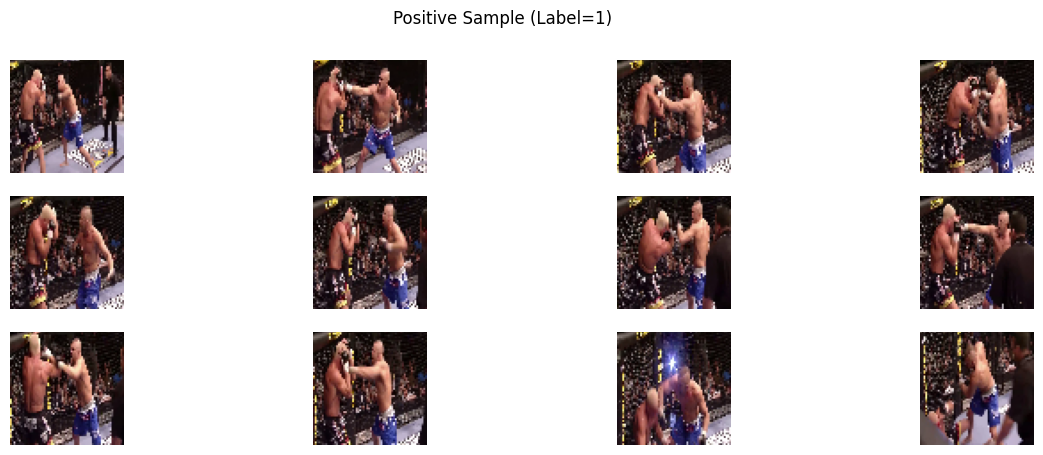

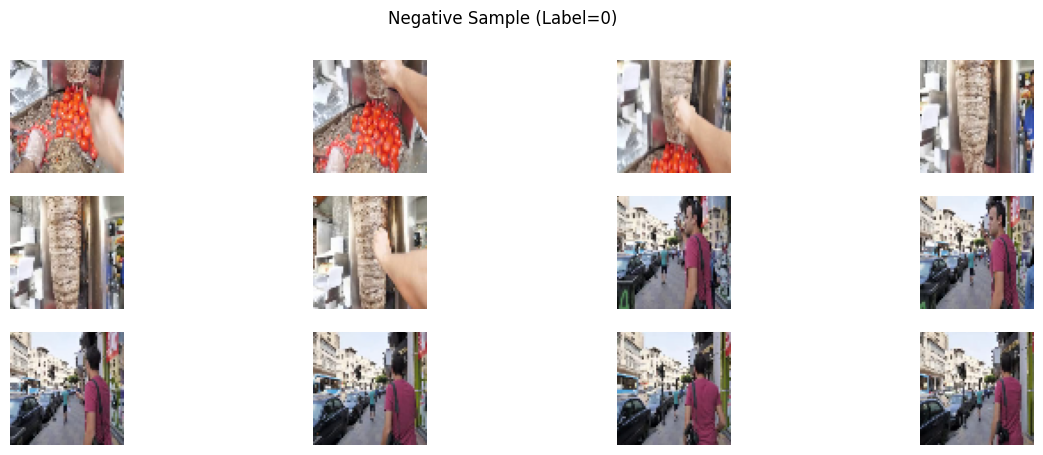

In [14]:
positive_sample = (positive_sample * 255).astype('uint8')
negative_sample = (negative_sample * 255).astype('uint8')

# Visualize the positive sample
visualize_sample(positive_sample, title='Positive Sample (Label=1)')

# Visualize the negative sample
visualize_sample(negative_sample, title='Negative Sample (Label=0)')

In [15]:

violence_val_generator = VideoDataGenerator(
    violence_val_videos,
    violence_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
)
violence_test_generator = VideoDataGenerator(
    violence_test_videos,
    violence_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
)

In [16]:
# TikTok dataset generators
tiktok_train_generator = VideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
)
tiktok_val_generator = VideoDataGenerator(
    tiktok_val_videos,
    tiktok_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
)
tiktok_test_generator = VideoDataGenerator(
    tiktok_test_videos,
    tiktok_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
)

## Baseline Classification with C3D Model

### Load and Compile the Model

In [17]:
# Load the base C3D model
base_model_c3d = load_c3d_model(input_shape=input_shape, feature_dim=feature_dim)
print("Base C3D Model Summary:")
base_model_c3d.summary()

Base C3D Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 32, 32, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 6

In [18]:
# Create classification model
def create_classification_model(base_model, num_classes):
    """Create a classification model by adding a dense layer on top of base_model."""
    features = base_model.output
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [19]:
def scheduler(epoch, lr):
    # 每隔10个epoch，学习率衰减为原来的0.5倍
    if epoch % 3 == 0 and epoch > 0:
        return lr * 0.01
    return lr
    

In [20]:
# Classification model for Violence dataset
classification_model_violence = create_classification_model(base_model_c3d, num_classes)
# Freeze base model layers
for layer in classification_model_violence.layers[:-1]:
    layer.trainable = False

# Compile the model
classification_model_violence.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[metrics.SparseCategoricalAccuracy()],
)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

In [21]:
print("Classification Model for Violence Dataset Summary:")
classification_model_violence.summary()

Classification Model for Violence Dataset Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 32, 32, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_

### Train and Evaluate on Violence Dataset

In [ ]:
 # Train the model on Violence dataset
history_violence = classification_model_violence.fit(
    violence_train_generator,
    validation_data=violence_val_generator,
    epochs=num_epochs,
    callbacks=[lr_scheduler],
)

Epoch 1/10
49/49 [==============================] - 34s 633ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4423 - lr: 1.0000e-05
Epoch 2/10
49/49 [==============================] - 32s 651ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5612 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4423 - lr: 1.0000e-05
Epoch 3/10
49/49 [==============================] - 31s 634ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.4719 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4423 - lr: 1.0000e-05
Epoch 4/10
49/49 [==============================] - 32s 660ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.5077 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4423 - lr: 1.0000e-07
Epoch 5/10
49/49 [==============================] - 32s 654ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.4847 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4423 - lr: 1.0000e-07
Epoch 6/10

In [23]:
# Evaluate on Violence test set
base_c3d_results_violence = classification_model_violence.evaluate(violence_test_generator)
print(f"Violence Dataset - Test Loss: {base_c3d_results_violence[0]:.4f}, Test Accuracy: {base_c3d_results_violence[1]:.4f}")


22/22 [==============================] - 11s 472ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4545
Violence Dataset - Test Loss: 0.6932, Test Accuracy: 0.4545


In [24]:
# Plot training & validation accuracy and loss
def plot_history(history, title):
    """Plot training and validation accuracy and loss."""
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

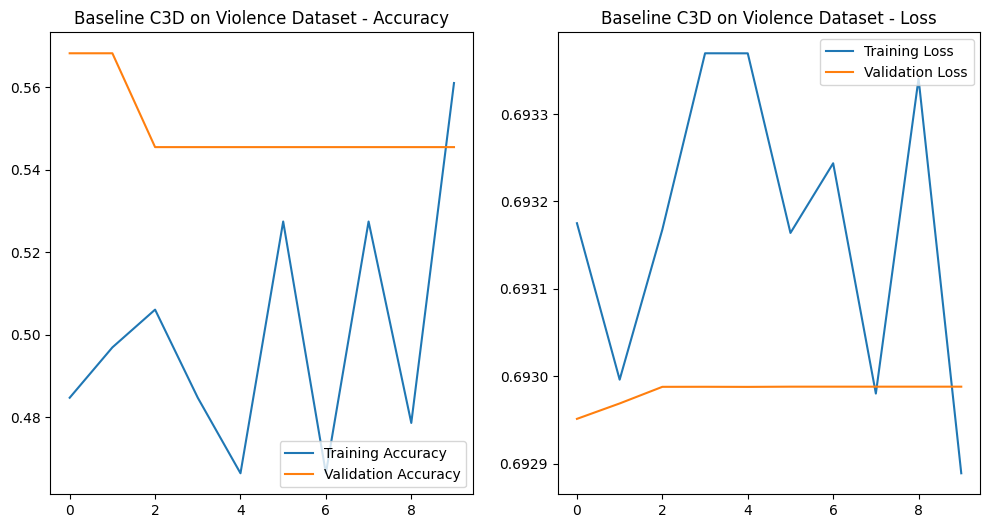

In [25]:
plot_history(history_violence, 'Baseline C3D on Violence Dataset')

In [32]:
# Display confusion matrix
def display_confusion_matrix(model, test_generator, class_names, title):
    """Display confusion matrix for the test set."""
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.labels

    print(len(y_pred_classes), len(y_true))
    
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{title} - Confusion Matrix')
    plt.show()

In [28]:
print(len(violence_test_generator))

22


In [33]:
class_names = ['NonViolence', 'Violence']
display_confusion_matrix(classification_model_violence, violence_test_generator, class_names, 'Baseline C3D on Violence Dataset')


22/22 [==============================] - 11s 468ms/step
88 90


ValueError: Found input variables with inconsistent numbers of samples: [90, 88]

In [29]:
"""
from tensorflow.keras.models import Model
import numpy as np

# 创建一个新模型，该模型的输出是原始模型中特征向量的层
feature_extraction_model = Model(
    inputs=classification_model_violence.input,
    outputs=classification_model_violence.layers[-2].output  # -2是指最后一个Dense层之前的特征层
)

# 使用验证集提取特征
features, labels = [], []
for batch_data, batch_labels in violence_val_generator:
    batch_features = feature_extraction_model.predict(batch_data)
    features.append(batch_features)
    labels.append(batch_labels)
    
# 合并所有批次的特征和标签
features = np.vstack(features)
labels = np.hstack(labels)"""

'\nfrom tensorflow.keras.models import Model\nimport numpy as np\n\n# 创建一个新模型，该模型的输出是原始模型中特征向量的层\nfeature_extraction_model = Model(\n    inputs=classification_model_violence.input,\n    outputs=classification_model_violence.layers[-2].output  # -2是指最后一个Dense层之前的特征层\n)\n\n# 使用验证集提取特征\nfeatures, labels = [], []\nfor batch_data, batch_labels in violence_val_generator:\n    batch_features = feature_extraction_model.predict(batch_data)\n    features.append(batch_features)\n    labels.append(batch_labels)\n    \n# 合并所有批次的特征和标签\nfeatures = np.vstack(features)\nlabels = np.hstack(labels)'

In [30]:
"""from sklearn.manifold import TSNE

# 使用t-SNE对特征进行降维，降到2维
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
features_2d = tsne.fit_transform(features)"""

'from sklearn.manifold import TSNE\n\n# 使用t-SNE对特征进行降维，降到2维\ntsne = TSNE(n_components=2, random_state=42,perplexity=5)\nfeatures_2d = tsne.fit_transform(features)'

In [31]:
"""# 可视化t-SNE降维后的特征分布
plt.figure(figsize=(10, 6))

# 使用不同的颜色来区分两类标签
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=f'Class {label}', alpha=0.7)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Features')
plt.legend()
plt.show()"""

"# 可视化t-SNE降维后的特征分布\nplt.figure(figsize=(10, 6))\n\n# 使用不同的颜色来区分两类标签\nfor label in np.unique(labels):\n    indices = np.where(labels == label)\n    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=f'Class {label}', alpha=0.7)\n\nplt.xlabel('t-SNE Component 1')\nplt.ylabel('t-SNE Component 2')\nplt.title('t-SNE Visualization of Features')\nplt.legend()\nplt.show()"

In [23]:
# Classification model for TikTok dataset
classification_model_tiktok = create_classification_model(base_model_c3d, num_classes)

# Freeze base model layers
for layer in classification_model_tiktok.layers[:-1]:
    layer.trainable = False

# Compile the model
classification_model_tiktok.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

print("Classification Model for TikTok Dataset Summary:")
classification_model_tiktok.summary()

Classification Model for TikTok Dataset Summary:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 32, 32, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_2 

In [24]:
# Train the model on TikTok dataset
history_tiktok = classification_model_tiktok.fit(
    tiktok_train_generator,
    validation_data=tiktok_val_generator,
    epochs=num_epochs,
    callbacks=[lr_scheduler],
)

Epoch 1/10
 9/41 [=====>........................] - ETA: 46s - loss: 0.6927 - sparse_categorical_accuracy: 0.5417

KeyboardInterrupt: 

30/30 [==============================] - 38s 1s/step - loss: 0.6955 - sparse_categorical_accuracy: 0.4833
TikTok Dataset - Test Loss: 0.6955, Test Accuracy: 0.4833


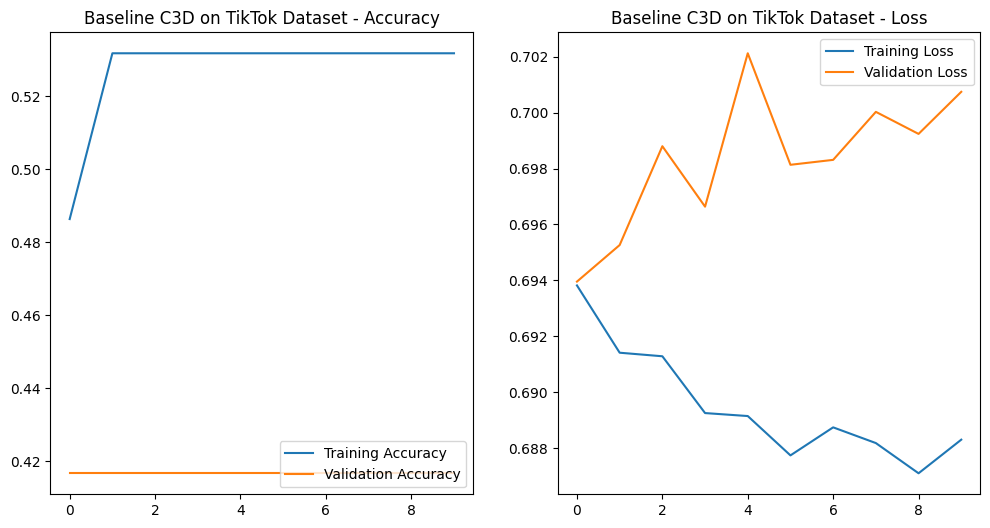

In [23]:
# Evaluate on TikTok test set
base_c3d_results_tiktok = classification_model_tiktok.evaluate(tiktok_test_generator)
print(f"TikTok Dataset - Test Loss: {base_c3d_results_tiktok[0]:.4f}, Test Accuracy: {base_c3d_results_tiktok[1]:.4f}")

plot_history(history_tiktok, 'Baseline C3D on TikTok Dataset')


30/30 [==============================] - 38s 1s/step


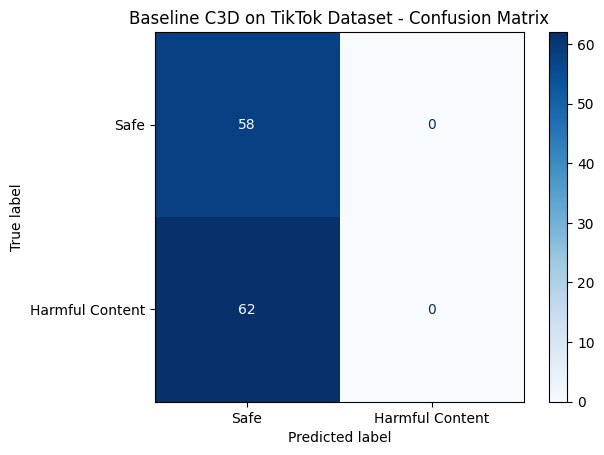

In [24]:
# Display confusion matrix
class_names = ['Safe', 'Harmful Content']
display_confusion_matrix(classification_model_tiktok, tiktok_test_generator, class_names, 'Baseline C3D on TikTok Dataset')


## Multi-dataset Supervised Contrastive Learning (MSupCL)

### Prepare Data for MSupCL

In [25]:
# Combine training data from both datasets
combined_train_videos = violence_train_videos + tiktok_train_videos
combined_train_labels = violence_train_labels_np.tolist() + tiktok_train_labels_np.tolist()

# Create a combined data generator
combined_train_generator = VideoDataGenerator(
    combined_train_videos,
    combined_train_labels,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
)

# Create paired data generators for MSupCL
violence_train_generator_no_aug = VideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=False,
)
tiktok_train_generator_no_aug = VideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=False,
)
paired_train_generator = MultiDatasetDataGenerator(
    violence_train_videos, violence_train_labels_np,
    tiktok_train_videos, tiktok_train_labels_np,
    batch_size=8,
    shuffle=True
)

### Load and Train MSupCL Model

In [26]:
# Load the MSupCL model
msupcl_model = load_c3d_model(input_shape=input_shape, feature_dim=feature_dim)
print("MSupCL Model Summary:")
msupcl_model.summary()

MSupCL Model Summary:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 12, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 6

In [27]:
# Train the MSupCL model
train_msupcl_model(msupcl_model, paired_train_generator, epochs=num_epochs, temperature=temperature)



Epoch 1/10
Training Loss: 2.8798
Epoch 2/10
Training Loss: 2.8702
Epoch 3/10
Training Loss: 2.8731
Epoch 4/10
Training Loss: 2.8757
Epoch 5/10
Training Loss: 2.8687
Epoch 6/10
Training Loss: 2.8745
Epoch 7/10
Training Loss: 2.8769
Epoch 8/10
Training Loss: 2.8677
Epoch 9/10
Training Loss: 2.8756
Epoch 10/10
Training Loss: 2.8716


### Evaluate MSupCL Model

In [ ]:
# Linear evaluation on both datasets
msupcl_c3d_result_violence, msupcl_c3d_result_tiktok = linear_evaluation(
    msupcl_model,
    combined_train_generator,
    violence_test_generator,
    tiktok_test_generator,
    num_classes=num_classes,
)

In [29]:
print(f"MSupCL C3D Violence Dataset - Test Accuracy: {msupcl_c3d_result_violence[1]:.4f}")
print(f"MSupCL C3D TikTok Dataset - Test Accuracy: {msupcl_c3d_result_tiktok[1]:.4f}")


MSupCL C3D Violence Dataset - Test Accuracy: 0.4917
MSupCL C3D TikTok Dataset - Test Accuracy: 0.5167


## Self-Supervised Contrastive Learning (SSCL) with SimCLR

### Prepare Data Generators for SSCL


In [30]:
# SSCL data generators for Violence dataset
violence_train_sscl_generator = SSCLVideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    double_view=True,
)
violence_train_single_sscl_generator = SSCLVideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
violence_val_sscl_generator = SSCLVideoDataGenerator(
    violence_val_videos,
    violence_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
violence_test_sscl_generator = SSCLVideoDataGenerator(
    violence_test_videos,
    violence_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)

# SSCL data generators for TikTok dataset
tiktok_train_sscl_generator = SSCLVideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    double_view=True,
)
tiktok_train_single_sscl_generator = SSCLVideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
tiktok_val_sscl_generator = SSCLVideoDataGenerator(
    tiktok_val_videos,
    tiktok_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
tiktok_test_sscl_generator = SSCLVideoDataGenerator(
    tiktok_test_videos,
    tiktok_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)


### Load and Train SSCL Model with C3D Backbone

In [31]:
# Load the SSCL model with C3D backbone
sscl_model_c3d = load_c3d_sscl_model(input_shape=input_shape, feature_dim=feature_dim)
print("SSCL Model with C3D Backbone Summary:")
sscl_model_c3d.summary()

SSCL Model with C3D Backbone Summary:
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 12, 32, 32, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 6, 16, 16, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)  

In [32]:
# Train SSCL model on Violence dataset
train_simclr_model(sscl_model_c3d, violence_train_sscl_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/10
Epoch 1, Loss: 1.9492
Epoch 2/10


KeyboardInterrupt: 

### Evaluate SSCL Model on Violence Dataset

In [27]:
# Linear evaluation on Violence dataset
sscl_c3d_result_violence = linear_evaluation_sscl(
    sscl_model_c3d,
    violence_train_single_sscl_generator,
    violence_val_sscl_generator,
    violence_test_sscl_generator,
    num_classes=num_classes,
)
print(f"SSCL C3D Violence Dataset - Test Accuracy: {sscl_c3d_result_violence[1]:.4f}")

Epoch 1/3
13/13 [==============================] - 24s 2s/step - loss: 1.6528 - accuracy: 0.5000 - val_loss: 1.0581 - val_accuracy: 0.4167
Epoch 2/3
13/13 [==============================] - 23s 2s/step - loss: 1.6627 - accuracy: 0.5385 - val_loss: 0.9736 - val_accuracy: 0.4167
Epoch 3/3
7/7 [==============================] - 11s 1s/step - loss: 0.7675 - accuracy: 0.5357
Test Loss: 0.7675142884254456, Test Accuracy: 0.5357142686843872


### Train and Evaluate SSCL Model on TikTok Dataset

In [ ]:
# Train SSCL model on TikTok dataset
train_simclr_model(sscl_model_c3d, tiktok_train_sscl_generator, epochs=num_epochs, temperature=temperature)

In [28]:

# Linear evaluation on TikTok dataset
sscl_c3d_result_tiktok = linear_evaluation_sscl(
    sscl_model_c3d,
    tiktok_train_single_sscl_generator,
    tiktok_val_sscl_generator,
    tiktok_test_sscl_generator,
    num_classes=num_classes,
)

print(f"SSCL C3D TikTok Dataset - Test Accuracy: {sscl_c3d_result_tiktok[1]:.4f}")


Epoch 1/3



KeyboardInterrupt



## Experiments with R(2+1)D-18 Model

### Baseline Classification with R(2+1)D-18 Model



In [29]:
# Load the base R(2+1)D model
base_model_r2plus1d = load_r2plus1d_model(input_shape=input_shape, feature_dim=feature_dim, include_top=False)
print("Base R(2+1)D Model Summary:")
base_model_r2plus1d.summary()

In [ ]:
# Create classification model
def create_classification_model_r2p1d(base_model, num_classes):
    """Create a classification model by adding a dense layer on top of base_model."""
    features = base_model.output
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [30]:
classification_model_r2p1d = create_classification_model_r2p1d(base_model_r2plus1d, num_classes)

# Freeze base model layers
for layer in classification_model_r2p1d.layers[:-1]:
    layer.trainable = False

# Compile the model
classification_model_r2p1d.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

### Train and Evaluate on Violence Dataset

In [31]:
# Train the model on Violence dataset
history_violence_r2p1d = classification_model_r2p1d.fit(
    violence_train_generator,
    validation_data=violence_val_generator,
    epochs=num_epochs
)

Epoch 1/3
13/13 [==============================] - 9s 578ms/step - loss: 0.7308 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6885 - val_sparse_categorical_accuracy: 0.5833
Epoch 2/3
13/13 [==============================] - 8s 612ms/step - loss: 0.7267 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6832 - val_sparse_categorical_accuracy: 0.5833
Epoch 3/3
13/13 [==============================] - 8s 590ms/step - loss: 0.7313 - sparse_categorical_accuracy: 0.4808 - val_loss: 0.6843 - val_sparse_categorical_accuracy: 0.5833


In [32]:
# Evaluate on Violence test set
base_r2plus1d_results_violence = classification_model_r2p1d.evaluate(violence_test_generator)
print(f"R(2+1)D Violence Dataset - Test Loss: {base_r2plus1d_results_violence[0]:.4f}, Test Accuracy: {base_r2plus1d_results_violence[1]:.4f}")

plot_history(history_violence_r2p1d, 'Baseline R(2+1)D on Violence Dataset')

# Display confusion matrix
display_confusion_matrix(classification_model_r2p1d, violence_test_generator, class_names, 'Baseline R(2+1)D on Violence Dataset')


7/7 [==============================] - 4s 499ms/step - loss: 0.7409 - sparse_categorical_accuracy: 0.4643
Violence Dataset - Test Loss: 0.7409264445304871, Test Accuracy: 0.4642857015132904


### Train and Evaluate on TikTok Dataset

In [33]:
# Train the model on TikTok dataset
history_tiktok_r2p1d = classification_model_r2p1d.fit(
    tiktok_train_generator,
    validation_data=tiktok_val_generator,
    epochs=num_epochs
)

Classification Model for TikTok Dataset Summary:
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_24 (Conv3D)             (None, 12, 32, 32,   9408        ['input_4[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 32, 32,   256        ['conv3d_24[0][0]']              
 alization)                     64)        

In [ ]:
# Evaluate on TikTok test set
base_r2plus1d_results_tiktok = classification_model_r2p1d.evaluate(tiktok_test_generator)
print(f"R(2+1)D TikTok Dataset - Test Loss: {base_r2plus1d_results_tiktok[0]:.4f}, Test Accuracy: {base_r2plus1d_results_tiktok[1]:.4f}")

plot_history(history_tiktok_r2p1d, 'Baseline R(2+1)D on TikTok Dataset')

# Display confusion matrix
display_confusion_matrix(classification_model_r2p1d, tiktok_test_generator, class_names, 'Baseline R(2+1)D on TikTok Dataset')


### MSupCL with R(2+1)D-18 Model

In [34]:
# Load the MSupCL model with R(2+1)D backbone
msupcl_model_r2p1d = load_r2plus1d_model(input_shape=input_shape, feature_dim=feature_dim, include_top=False)
print("MSupCL Model with R(2+1)D Backbone Summary:")
msupcl_model_r2p1d.summary()


MSupCL Model Summary:
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_60 (Conv3D)             (None, 12, 32, 32,   9408        ['input_5[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 12, 32, 32,   256        ['conv3d_60[0][0]']              
 ormalization)                  64)                                  

In [36]:
# Train MSupCL model
train_msupcl_model(msupcl_model_r2p1d, paired_train_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/3
Training Loss: 7.4534
Epoch 2/3
Training Loss: 7.3422
Epoch 3/3


KeyboardInterrupt: 

In [34]:
# Linear evaluation on both datasets
msupcl_r2p1d_result_violence, msupcl_r2p1d_result_tiktok = linear_evaluation(
    msupcl_model_r2p1d,
    combined_train_generator,
    violence_test_generator,
    tiktok_test_generator,
    num_classes=num_classes,
)

print(f"MSupCL R(2+1)D Violence Dataset - Test Accuracy: {msupcl_r2p1d_result_violence[1]:.4f}")
print(f"MSupCL R(2+1)D TikTok Dataset - Test Accuracy: {msupcl_r2p1d_result_tiktok[1]:.4f}")



Epoch 1/5
27/27 [==============================] - 28s 1000ms/step - loss: 0.6929 - accuracy: 0.5278
Epoch 2/5
27/27 [==============================] - 26s 981ms/step - loss: 0.6929 - accuracy: 0.5185
Epoch 3/5
27/27 [==============================] - 25s 945ms/step - loss: 0.6918 - accuracy: 0.5278
Epoch 4/5
27/27 [==============================] - 25s 952ms/step - loss: 0.6918 - accuracy: 0.5231
Epoch 5/5
27/27 [==============================] - 26s 962ms/step - loss: 0.6912 - accuracy: 0.5278
Evaluating on Violence Test Set:
7/7 [==============================] - 4s 519ms/step - loss: 0.6929 - accuracy: 0.5357
Violence Test Loss: 0.6928600072860718, Test Accuracy: 0.5357142686843872
Evaluating on TikTok Test Set:
7/7 [==============================] - 9s 1s/step - loss: 0.6928 - accuracy: 0.4643
TikTok Test Loss: 0.6928288340568542, Test Accuracy: 0.4642857015132904


### SSCL with R(2+1)D-18 Model

In [13]:
# Load the SSCL model with R(2+1)D backbone
sscl_model_r2p1d = load_sscl_r2plus1d_model(input_shape=input_shape, feature_dim=feature_dim)
print("SSCL Model with R(2+1)D Backbone Summary:")
sscl_model_r2p1d.summary()

In [14]:
# Train SSCL model on Violence dataset
train_simclr_model(sscl_model_r2p1d, violence_train_sscl_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/3
Epoch 1, Loss: 1.9036
Epoch 2/3
Epoch 2, Loss: 1.7317
Epoch 3/3
Epoch 3, Loss: 1.8153


In [15]:
# Linear evaluation on Violence dataset
sscl_r2p1d_result_violence = linear_evaluation_sscl(
    sscl_model_r2p1d,
    violence_train_single_sscl_generator,
    violence_val_sscl_generator,
    violence_test_sscl_generator,
    num_classes=num_classes,
)

print(f"SSCL R(2+1)D Violence Dataset - Test Accuracy: {sscl_r2p1d_result_violence[1]:.4f}")


Epoch 1/3
13/13 [==============================] - 25s 2s/step - loss: 0.7587 - accuracy: 0.4808 - val_loss: 0.6889 - val_accuracy: 0.5833
Epoch 2/3
13/13 [==============================] - 23s 2s/step - loss: 0.7337 - accuracy: 0.5000 - val_loss: 0.6801 - val_accuracy: 0.5833
Epoch 3/3
7/7 [==============================] - 11s 2s/step - loss: 0.7312 - accuracy: 0.4643
Test Loss: 0.7312026619911194, Test Accuracy: 0.4642857015132904


### Train and Evaluate SSCL Model on TikTok Dataset

In [16]:
# Train SSCL model on TikTok dataset
train_simclr_model(sscl_model_r2p1d, tiktok_train_sscl_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/3


KeyboardInterrupt: 

In [ ]:
# Linear evaluation on TikTok dataset
sscl_r2p1d_result_tiktok = linear_evaluation_sscl(
    sscl_model_r2p1d,
    tiktok_train_single_sscl_generator,
    tiktok_val_sscl_generator,
    tiktok_test_sscl_generator,
    num_classes=num_classes,
)

print(f"SSCL R(2+1)D TikTok Dataset - Test Accuracy: {sscl_r2p1d_result_tiktok[1]:.4f}")


## Summary of Results

In [ ]:
# Create a summary table of results
import pandas as pd

results = {
    'Model': ['Baseline C3D', 'MSupCL C3D', 'SSCL C3D', 'Baseline R(2+1)D', 'MSupCL R(2+1)D', 'SSCL R(2+1)D'],
    'Violence Accuracy': [
        base_c3d_results_violence[1],
        msupcl_c3d_result_violence[1],
        sscl_c3d_result_violence[1],
        base_r2plus1d_results_violence[1],
        msupcl_r2p1d_result_violence[1],
        sscl_r2p1d_result_violence[1],
    ],
    'TikTok Accuracy': [
        base_c3d_results_tiktok[1],
        msupcl_c3d_result_tiktok[1],
        sscl_c3d_result_tiktok[1],
        base_r2plus1d_results_tiktok[1],
        msupcl_r2p1d_result_tiktok[1],
        sscl_r2p1d_result_tiktok[1],
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
# Plot the accuracies
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df['Model']))
width = 0.35

plt.bar(x - width/2, results_df['Violence Accuracy'], width, label='Violence Dataset')
plt.bar(x + width/2, results_df['TikTok Accuracy'], width, label='TikTok Dataset')

plt.ylabel('Accuracy')
plt.title('Comparison of Models on Violence and TikTok Datasets')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()